https://www.kaggle.com/code/ryanholbrook/mutual-information/tutorial

### Introduction
First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

### Mutual Information and What it Measures
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which _**knowledge of one quantity reduces uncertainty about the other**_. If you knew the value of a feature, how much more confident would you be about the target?

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". _**The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average."**_ The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

### Here are some things to remember when applying mutual information:

- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [2]:
# %load ../../import_matplot.py
import pandas as pd
import jlam.eda_util as edu
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


pd.set_option('display.max_rows',500)

# global settings
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11,5))
plt.rc("axes", 
           labelweight="bold", labelsize="large",
           titleweight="bold", titlesize=14, titlepad=10
          )

In [3]:
df = pd.read_csv('data/autos.csv')
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    object 
 2   fuel_type          193 non-null    object 
 3   aspiration         193 non-null    object 
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    object 
 6   drive_wheels       193 non-null    object 
 7   engine_location    193 non-null    object 
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    object 
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

In [5]:
# separating target
X = df.copy()
y = X.pop("price")

In [6]:
# Label encoding for categoricals
for col in X.select_dtypes(include='object'):
    X[col], _ = X[col].factorize()

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    int64  
 2   fuel_type          193 non-null    int64  
 3   aspiration         193 non-null    int64  
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    int64  
 6   drive_wheels       193 non-null    int64  
 7   engine_location    193 non-null    int64  
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    int64  
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

In [9]:
df.make.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mercury',
       'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [10]:
X.make.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [13]:
discrete_features = X.dtypes == int
discrete_features

symboling             True
make                  True
fuel_type             True
aspiration            True
num_of_doors          True
body_style            True
drive_wheels          True
engine_location       True
wheel_base           False
length               False
width                False
height               False
curb_weight           True
engine_type           True
num_of_cylinders      True
engine_size           True
fuel_system           True
bore                 False
stroke               False
compression_ratio     True
horsepower            True
peak_rpm              True
city_mpg              True
highway_mpg           True
dtype: bool

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [14]:
from sklearn.feature_selection import mutual_info_regression

In [15]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [16]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[:3]

Checking X array...


curb_weight    1.485626
horsepower     1.260319
engine_size    0.999090
Name: MI Scores, dtype: float64

In [17]:
mi_scores[::3]

curb_weight          1.485626
highway_mpg          0.958562
length               0.602030
bore                 0.483993
stroke               0.394295
num_of_cylinders     0.331096
compression_ratio    0.133016
fuel_type            0.047279
Name: MI Scores, dtype: float64

In [19]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

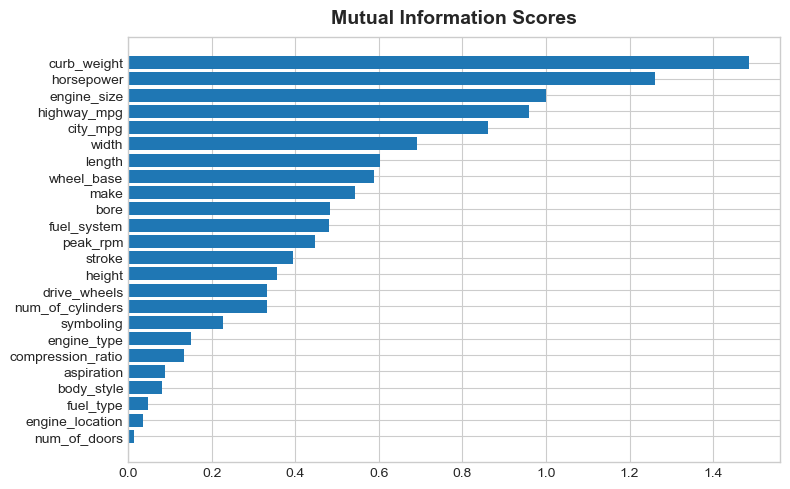

In [20]:
plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)

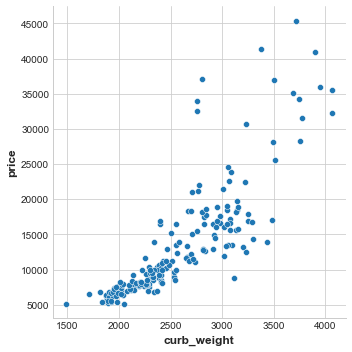

In [21]:
sns.relplot(x='curb_weight', y="price", data=df)

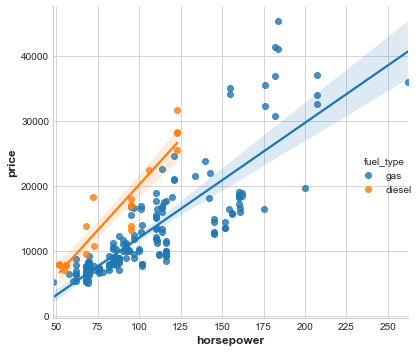

In [22]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);